#Efficient SAM Example

This script provides example for how to get visualization result from EfficientSAM using weight file, part of the code is borrow from MobileSAM project, many thanks!

##Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.transforms import ToTensor
from PIL import Image
import io
from os import listdir, makedirs
from os.path import join, isfile, basename
from glob import glob

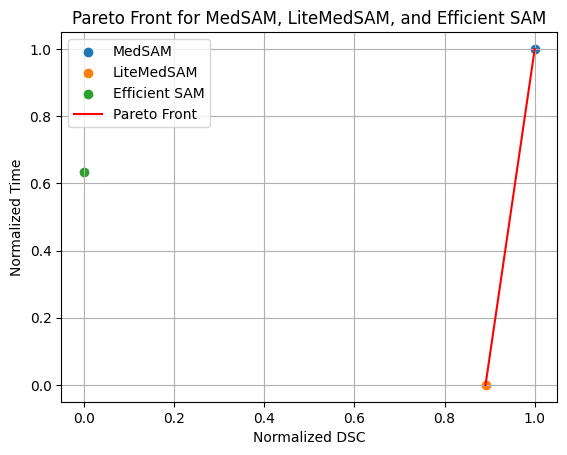

In [4]:
import matplotlib.pyplot as plt

# Define the normalized DSC and Time values for each model
medsam_dsc = 1
medsam_time = 1

litemedsam_dsc = 0.8909
litemedsam_time = 0

efficientsam_dsc = 0
efficientsam_time = 0.6332

# Plot the points for each model
plt.scatter(medsam_dsc, medsam_time, label='MedSAM')
plt.scatter(litemedsam_dsc, litemedsam_time, label='LiteMedSAM')
plt.scatter(efficientsam_dsc, efficientsam_time, label='Efficient SAM')

# Plot the Pareto front
pareto_front = [(medsam_dsc, medsam_time), (litemedsam_dsc, litemedsam_time)]
plt.plot(*zip(*pareto_front), color='red', label='Pareto Front')

# Add labels and legend
plt.xlabel('Normalized DSC')
plt.ylabel('Normalized Time')
plt.title('Pareto Front for MedSAM, LiteMedSAM, and Efficient SAM')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


#Box and Point prompt

In [2]:
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    print(img_tensor.shape)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()

#Visualization Related

In [5]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.8])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="yellow", facecolor=(0, 0, 0, 0), lw=5)
    )

def show_anns_ours(mask, ax):
    ax.set_autoscale_on(False)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:, :, 3] = 0
    color_mask = [0, 1, 0, 0.7]
    img[np.logical_not(mask)] = color_mask
    ax.imshow(img)


#Create the model and load the weights from the checkpoint.

In [3]:
# !git clone https://github.com/yformer/EfficientSAM.git
import os
os.chdir("../../EfficientSAM")

In [4]:
from efficient_sam.build_efficient_sam import build_efficient_sam_vitt, build_efficient_sam_vits
# from squeeze_sam.build_squeeze_sam import build_squeeze_sam
import zipfile

efficient_sam_vitt_model = build_efficient_sam_vitt()
efficient_sam_vitt_model.eval()

# Since EfficientSAM-S checkpoint file is >100MB, we store the zip file.
# with zipfile.ZipFile("weights/efficient_sam_vits.pt.zip", 'r') as zip_ref:
#     zip_ref.extractall("weights")
# efficient_sam_vits_model = build_efficient_sam_vits()
# efficient_sam_vits_model.eval()

# squeeze_sam_model = build_squeeze_sam()
# squeeze_sam_model.eval()


EfficientSam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=768, out_features=192, bias=True)
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(192, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )
 

## Box segmentation

prepare your own image here

In [9]:
"""
def run_ours_box_or_points(img_path, pts_sampled, pts_labels, model):
    image_np = np.array(Image.open(img_path))
    img_tensor = ToTensor()(image_np)
    pts_sampled = torch.reshape(torch.tensor(pts_sampled), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(pts_labels), [1, 1, -1])
    predicted_logits, predicted_iou = model(
        img_tensor[None, ...],
        pts_sampled,
        pts_labels,
    )

    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy()
"""
def efficientsam_infer(embddings, box, model, H, W):
    input_label = np.array([2,3])
    
    pts_sampled = torch.reshape(torch.tensor(box), [1, 1, -1, 2])
    pts_labels = torch.reshape(torch.tensor(input_label), [1, 1, -1])
    predicted_logits, predicted_iou = model.predict_masks(embddings, pts_sampled, pts_labels, True, H,W, H, W)
    sorted_ids = torch.argsort(predicted_iou, dim=-1, descending=True)
    predicted_iou = torch.take_along_dim(predicted_iou, sorted_ids, dim=2)
    predicted_logits = torch.take_along_dim(
        predicted_logits, sorted_ids[..., None, None], dim=2
    )

    return torch.ge(predicted_logits[0, 0, 0, :, :], 0).cpu().detach().numpy() 
def show_mask(mask, ax, mask_color=None, alpha=0.5):
    """
    show mask on the image

    Parameters
    ----------
    mask : numpy.ndarray
        mask of the image
    ax : matplotlib.axes.Axes
        axes to plot the mask
    mask_color : numpy.ndarray
        color of the mask
    alpha : float
        transparency of the mask
    """
    if mask_color is not None:
        color = np.concatenate([mask_color, np.array([alpha])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, alpha])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax, edgecolor='blue'):
    """
    show bounding box on the image

    Parameters
    ----------
    box : numpy.ndarray
        bounding box coordinates in the original image
    ax : matplotlib.axes.Axes
        axes to plot the bounding box
    edgecolor : str
        color of the bounding box
    """
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor=edgecolor, facecolor=(0,0,0,0), lw=2))     



In [35]:
data_root = '/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs/'
img_npz_files = sorted(glob(join(data_root, '*.npz'), recursive=True))
img_npz_file = img_npz_files[0]
npz_name = basename(img_npz_file)
npz_data = np.load(img_npz_file, 'r', allow_pickle=True) # (H, W, 3)
img_3c = npz_data['imgs'] # (H, W, 3)
print(f'input data shape: {img_3c.shape}')
assert np.max(img_3c)<256, f'input data should be in range [0, 255], but got {np.unique(img_3c)}'
H, W = img_3c.shape[:2]
boxes = npz_data['boxes']
segs = np.zeros(img_3c.shape[:2], dtype=np.uint8)

img_tensor = ToTensor()(img_3c)
img_tensor = img_tensor[None, ...]
print(f'input tensor shape: {img_tensor.shape}')
## preprocessing
img_1024 = efficient_sam_vitt_model.preprocess(img_tensor)
print(f'preprocessed data shape: {img_1024.shape}')
# img_1024 = resize_longest_side(img_3c, 1024)
# newh, neww = img_1024.shape[:2]
# img_1024_norm = (img_1024 - img_1024.min()) / np.clip(
#     img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
# )
# img_1024_padded = pad_image(img_1024_norm, 1024)
# img_1024_tensor = torch.tensor(img_1024_padded).float().permute(2, 0, 1).unsqueeze(0).to(device)

with torch.no_grad():
    image_embedding = efficient_sam_vitt_model.image_encoder(img_1024)

for idx, box in enumerate(boxes, start=1):
    # box1024 = resize_box_to_1024(box, original_size=(H, W))
    # box1024 = box1024[None, ...] # (1, 4)
    medsam_mask = efficientsam_infer(image_embedding, box, efficient_sam_vitt_model, H,W)
    # print('seg shape', segs.shape, 'medsam_mask shape', medsam_mask.shape)
    segs[medsam_mask>0] = idx
    # print(f'{npz_name}, box: {box}, predicted iou: {np.round(iou_pred.item(), 4)}')

input data shape: (256, 256, 3)
input tensor shape: torch.Size([1, 3, 256, 256])
preprocessed data shape: torch.Size([1, 3, 1024, 1024])


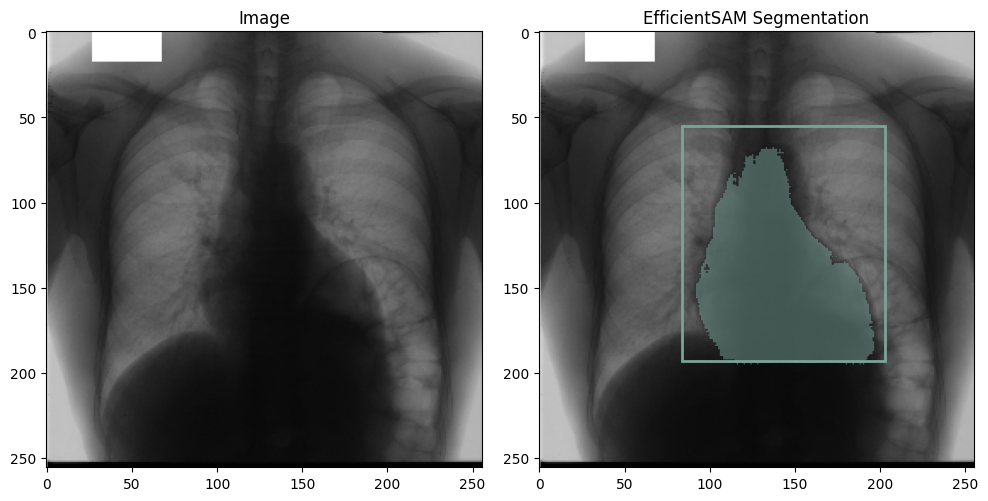

In [36]:

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
ax[1].imshow(img_3c)
ax[0].set_title("Image")
ax[1].set_title("EfficientSAM Segmentation")
# ax[0].axis('off')
# ax[1].axis('off')

for i, box in enumerate(boxes):
    color = np.random.rand(3)
    box_viz = box
    show_box(box_viz, ax[1], edgecolor=color)
    show_mask((segs == i+1).astype(np.uint8), ax[1], mask_color=color)

plt.tight_layout()

In [26]:
data_root = '/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs/'
img_npz_files = sorted(glob(join(data_root, '*.npz'), recursive=True))
img_npz_file = img_npz_files[-1]
npz_name = basename(img_npz_file)
npz_data = np.load(img_npz_file, 'r', allow_pickle=True) # (H, W, 3)
img_3D = npz_data['imgs'] # (D, H, W)
print(f'input data shape: {img_3D.shape}')
spacing = npz_data['spacing'] # not used in this demo because it treats each slice independently
segs = np.zeros_like(img_3D, dtype=np.uint8) 
boxes_3D = npz_data['boxes'] # [[x_min, y_min, z_min, x_max, y_max, z_max]]


input data shape: (74, 240, 240)


In [5]:
def get_bbox(mask, bbox_shift=3):
    """
    Get the bounding box coordinates from the mask (256x256)

    Parameters
    ----------
    mask_1024 : numpy.ndarray
        the mask of the resized image

    bbox_shift : int
        Add perturbation to the bounding box coordinates
    
    Returns
    -------
    numpy.ndarray
        bounding box coordinates in the resized image
    """
    y_indices, x_indices = np.where(mask > 0)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    # add perturbation to bounding box coordinates and test the robustness
    # this can be removed if you do not want to test the robustness
    H, W = mask.shape
    x_min = max(0, x_min - bbox_shift)
    x_max = min(W, x_max + bbox_shift)
    y_min = max(0, y_min - bbox_shift)
    y_max = min(H, y_max + bbox_shift)

    bboxes = np.array([x_min, y_min, x_max, y_max])

    return bboxes

In [12]:
data_root = '/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs/'
img_npz_files = sorted(glob(join(data_root, '*.npz'), recursive=True))
img_npz_file = img_npz_files[-1]
print(img_npz_file)
npz_name = basename(img_npz_file)
npz_data = np.load(img_npz_file, 'r', allow_pickle=True) # (H, W, 3)
img_3D = npz_data['imgs'] # (D, H, W)
print(f'input data shape: {img_3D.shape}')
spacing = npz_data['spacing'] # not used in this demo because it treats each slice independently
segs = np.zeros_like(img_3D, dtype=np.uint8) 
boxes_3D = npz_data['boxes'] # [[x_min, y_min, z_min, x_max, y_max, z_max]]

for idx, box3D in enumerate(boxes_3D, start=1):
    segs_3d_temp = np.zeros_like(img_3D, dtype=np.uint8) 
    x_min, y_min, z_min, x_max, y_max, z_max = box3D
    assert z_min < z_max, f"z_min should be smaller than z_max, but got {z_min=} and {z_max=}"
    mid_slice_bbox_2d = np.array([x_min, y_min, x_max, y_max])
    z_middle = int((z_max - z_min)/2 + z_min)
    # print(npz_name, 'infer from middle slice to the z_max')
    for z in range(z_middle, z_max):
        img_2d = img_3D[z, :, :]
        if len(img_2d.shape) == 2:
            img_3c = np.repeat(img_2d[:, :, None], 3, axis=-1)
        else:
            img_3c = img_2d
        H, W, _ = img_3c.shape
        img_tensor = ToTensor()(img_3c)
        img_tensor = img_tensor[None, ...]
        img_1024 = efficient_sam_vitt_model.preprocess(img_tensor)

        # get the image embedding
        with torch.no_grad():
            image_embedding = efficient_sam_vitt_model.image_encoder(img_1024) # (1, 256, 64, 64)
        
        if z != z_middle:
            pre_seg = segs[z-1, :, :]
            if np.max(pre_seg) > 0:
                box = get_bbox(pre_seg)
            else:
                box = mid_slice_bbox_2d
        else:
            box = mid_slice_bbox_2d
        mask = efficientsam_infer(image_embedding, box, efficient_sam_vitt_model, H,W)
        segs_3d_temp[z, mask>0] = idx
    
    # infer from middle slice to the z_max
    # print(npz_name, 'infer from middle slice to the z_min')
    for z in range(z_middle-1, z_min, -1):
        img_2d = img_3D[z, :, :]
        if len(img_2d.shape) == 2:
            img_3c = np.repeat(img_2d[:, :, None], 3, axis=-1)
        else:
            img_3c = img_2d
        H, W, _ = img_3c.shape

        img_tensor = ToTensor()(img_3c) 
        img_tensor = img_tensor[None, ...]
        img_1024 = efficient_sam_vitt_model.preprocess(img_tensor)
        # get the image embedding
        with torch.no_grad():
            image_embedding = efficient_sam_vitt_model.image_encoder(img_1024) # (1, 256, 64, 64)

        pre_seg = segs[z+1, :, :]
        if np.max(pre_seg) > 0:
            box = get_bbox(pre_seg)
        else:
            box = mid_slice_bbox_2d
        mask = efficientsam_infer(image_embedding, box, efficient_sam_vitt_model, H,W)
        segs_3d_temp[z, mask>0] = idx
    segs[segs_3d_temp>0] = idx


/scratch/project/bollmann_lab/MedSAM_Laptop/datasets/test_demo/imgs/3DBox_MR_demo.npz
input data shape: (74, 240, 240)


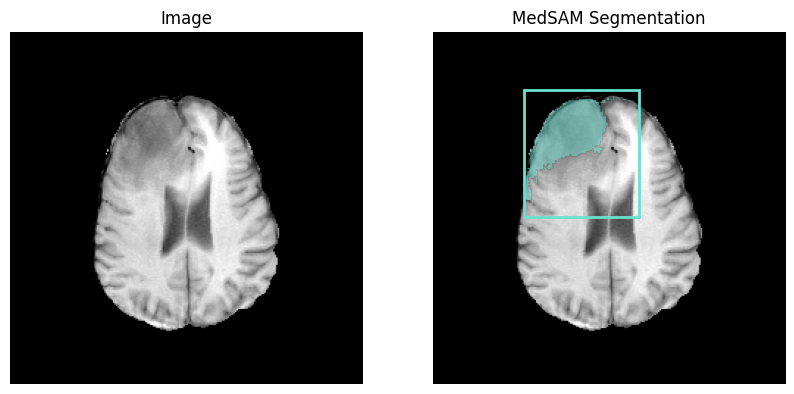

In [10]:
idx = int(segs.shape[0] / 2)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3D[idx], cmap='gray')
ax[1].imshow(img_3D[idx], cmap='gray')
ax[0].set_title("Image")
ax[1].set_title("MedSAM Segmentation")
ax[0].axis('off')
ax[1].axis('off')

for i, box3D in enumerate(boxes_3D, start=1):
    if np.sum(segs[idx]==i) > 0:
        color = np.random.rand(3)
        x_min, y_min, z_min, x_max, y_max, z_max = box3D
        box_viz = np.array([x_min, y_min, x_max, y_max])
        show_box(box_viz, ax[1], edgecolor=color)
        show_mask(segs[idx]==i, ax[1], mask_color=color)

torch.Size([3, 603, 1072])
(603, 1072, 3) (603, 1072)


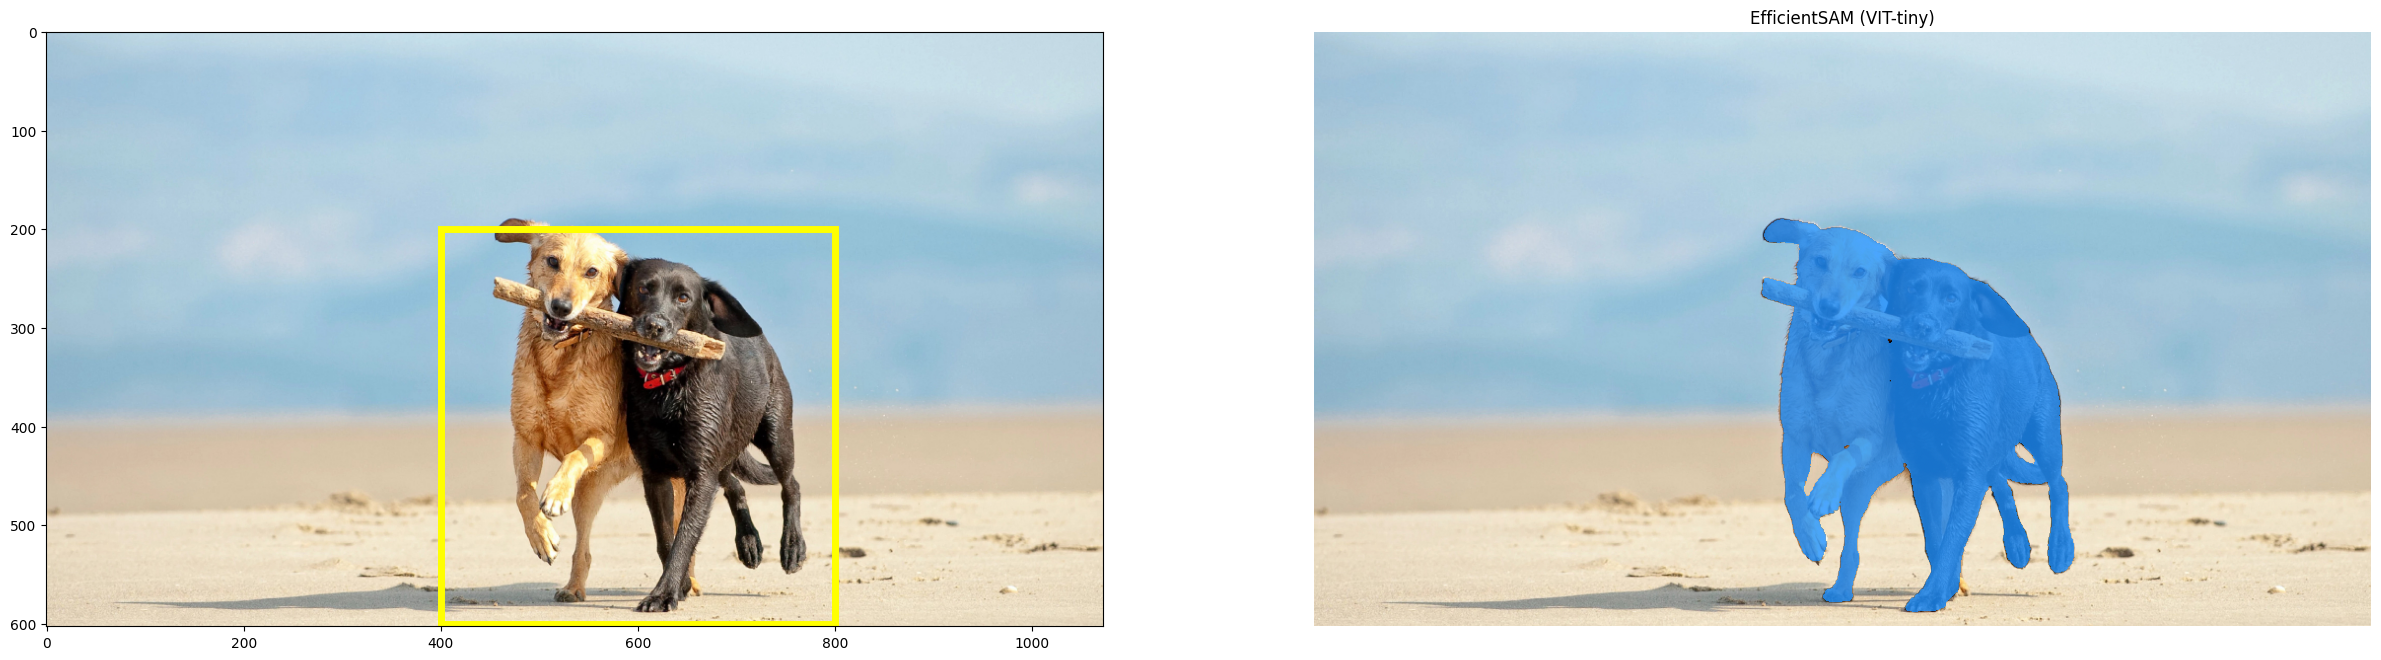

In [7]:
x1=400
y1=200
x2=800
y2=600
w=x2-x1
h=y2-y1

fig, ax = plt.subplots(1, 2, figsize=(30, 30))
input_point = np.array([[x1, y1], [x2, y2]])
input_label = np.array([2,3])
image_path = "figs/examples/dogs.jpg"
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
show_box([x1,y1,x2,y2], ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
# show_anns_ours(mask_efficient_sam_vitt, ax[1])
show_mask(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis('off')
print(image.shape, mask_efficient_sam_vitt.shape)
# ax[2].imshow(image)
# mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
# show_anns_ours(mask_efficient_sam_vits, ax[2])
# ax[2].title.set_text("EfficientSAM (VIT-small)")
# ax[2].axis('off')


# ax[3].imshow(image)
# mask_squeeze_sam = run_ours_box_or_points(image_path, input_point, input_label, squeeze_sam_model)
# show_anns_ours(mask_squeeze_sam, ax[3])
# ax[3].title.set_text("SqueezeSAM")
# ax[3].axis('off')

plt.show()

## Point segmentation

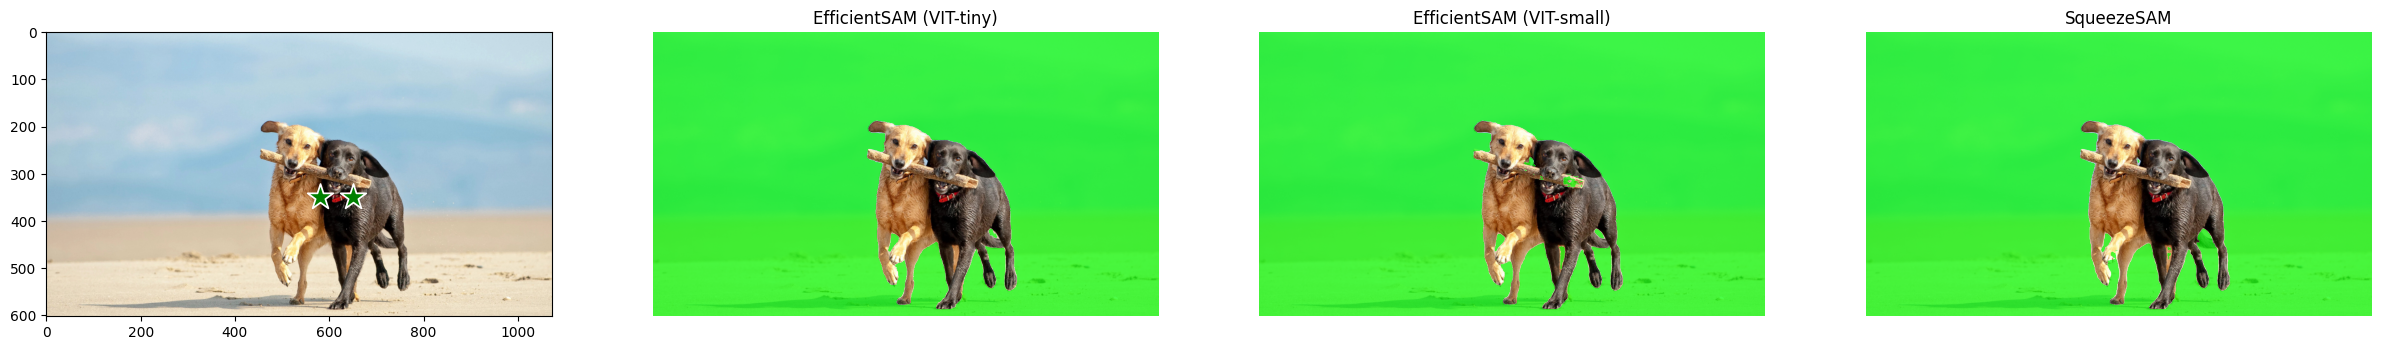

In [42]:
fig, ax = plt.subplots(1, 4, figsize=(30, 30))

input_label = np.array([1, 1])
image_path = "figs/examples/dogs.jpg"
input_point = np.array([[580, 350], [650, 350]])
image = np.array(Image.open(image_path))
show_points(input_point, input_label, ax[0])
ax[0].imshow(image)


ax[1].imshow(image)
mask_efficient_sam_vitt = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vitt_model)
show_anns_ours(mask_efficient_sam_vitt, ax[1])
ax[1].title.set_text("EfficientSAM (VIT-tiny)")
ax[1].axis('off')

ax[2].imshow(image)
mask_efficient_sam_vits = run_ours_box_or_points(image_path, input_point, input_label, efficient_sam_vits_model)
show_anns_ours(mask_efficient_sam_vits, ax[2])
ax[2].title.set_text("EfficientSAM (VIT-small)")
ax[2].axis('off')


ax[3].imshow(image)
mask_squeeze_sam = run_ours_box_or_points(image_path, input_point, input_label, squeeze_sam_model)
show_anns_ours(mask_squeeze_sam, ax[3])
ax[3].title.set_text("SqueezeSAM")
ax[3].axis('off')

plt.show()